In [35]:
import pandas as pd 
import rasterio as rio
import numpy as np

import glob

from joblib import Parallel, delayed


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

from sklearn.manifold import TSNE
import hdbscan
from utils.constants import DEPTS, YEARS
from sklearn.cluster import KMeans, DBSCAN



In [3]:
def nodata_to_zero(array: np.array, no_data: int) -> np.array:
    array = np.where(array != no_data, array, 0)
    return array


def load_merged_subtile(file_name: str, width: int, height: int) -> np.array:
    # Channels, H, W
    subtile = np.zeros((6, width, height))

    with rio.open(file_name) as src:
        temp_arr = src.read()
        no_data = src.nodata

    if no_data != 0:
        temp_arr = nodata_to_zero(temp_arr, no_data)

    subtile[:, : temp_arr.shape[1], : temp_arr.shape[2]] = temp_arr

    return subtile


def load_pixel(file_name: str) -> np.array:
    with rio.open(file_name) as src:
        temp_arr = src.read()
        no_data = src.nodata

    if no_data != 0:
        temp_arr = nodata_to_zero(temp_arr, no_data)
    
    return temp_arr

def check_zero(number):
    if np.all(number == 0):
        return False  
    return True

In [7]:
paths = []
for dept in DEPTS:
    for year in YEARS:
        paths.extend(glob.glob(f"../french_dept_data/{dept}/{year}/split*_1/*"))

In [4]:
subDEPTS = ['Ain', 'Aisne', 'Alpes_de_Haute_Provence','Alpes_Maritimes', 'Ardeche', 'Var', 'Vienne', 'Alpes_Maritimes']
subYEARS = ['2018', '2017', '2016']

def get_glob_paths(dept, year):
    return glob.glob(f"../french_dept_data/{dept}/{year}/split*_1/*")

paths = Parallel(n_jobs=8)(delayed(get_glob_paths)(dept, year) for year in subYEARS for dept in subDEPTS)

In [5]:
def flatten(t):
    return [item for sublist in t for item in sublist]

paths = flatten(paths)
print(len(paths))

383397


In [19]:
non_empty_pixels = []

for path in paths[:10000]:
    arr = load_pixel(path)
    non_empty_pixels.append(arr)

In [6]:
non_empty_pixels = Parallel(n_jobs=8)(delayed(load_pixel)(path) for path in paths)

In [7]:
non_empty_pixels = list(filter(check_zero, non_empty_pixels))

In [8]:
len(non_empty_pixels)

211737

In [9]:
arr = np.array(non_empty_pixels)

In [10]:
arr = arr.reshape(len(non_empty_pixels), 6)

In [11]:
arr = np.asarray(arr, dtype='float64')

In [12]:
np.save("sub_pixels.npy", arr)

In [39]:
data = TSNE(n_components=2,init='random').fit_transform(arr[:10000, :])

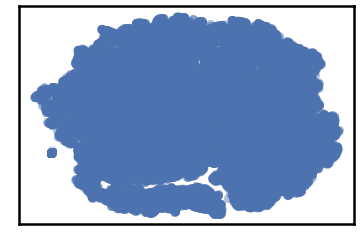

In [22]:
plt.scatter(*data.T, c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

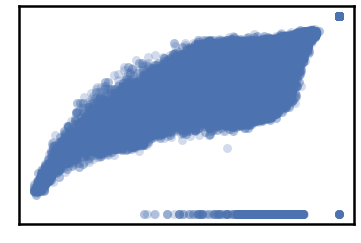

In [33]:
plt.scatter(arr[:,4], arr[:,5], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

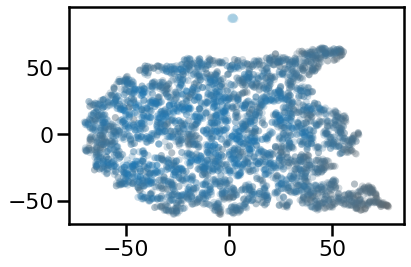

In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20).fit(arr[:5000, :])
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

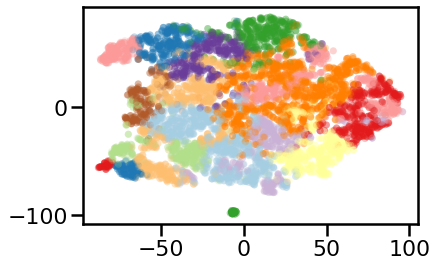

In [40]:
k_means = KMeans(20).fit(arr[:10000, :])
color_palette = sns.color_palette('Paired', 20)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in k_means.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, k_means.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

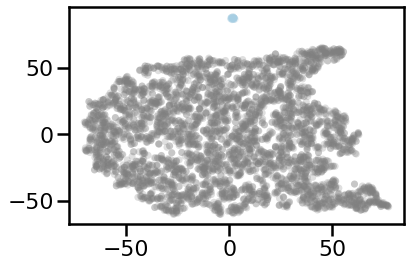

In [36]:
k_means = DBSCAN().fit(arr[:5000, :])
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in k_means.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, k_means.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)